In [1]:
'''
Usage:
1. Data directory must be in the same directory as the script
2. Images, lables and superpixels directories must be inside data directory
3. Script parameters must be specified in script parameters cell
'''

'\nUsage:\n1. Data directory must be in the same directory as the script\n2. Images, lables and superpixels directories must be inside data directory\n3. Script parameters must be specified in script parameters cell\n'

In [48]:
import numpy as np
import os
import collections
import matplotlib.pyplot as plt
import skimage.future.graph as skigraph
import shutil
import pickle
import keras
import tensorflow as tf
import networkx as nx
import time
import sys

from kgcnn.literature.GCN import make_model
from kgcnn.utils.data import ragged_tensor_from_nested_numpy
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from kgcnn.utils.learning import LinearLearningRateScheduler
from PIL import Image, ImageOps

In [49]:
# config

# script parameterss
MAIN_DIR_PATH = "/home/daniel/Praca inżynierska/DetectingInflammationsInImagesOfSacroiliacJoint"
DATA_DIR_NAME = "input/data_set_2"
IMAGES_DIR_NAME = "images"
SUPERPIXELS_LABELS_DIR_NAME = "labels"
SUPERPIXELS_DIR_NAME = "superpixels"
MASKS_DIR_NAME = "masks"

IMAGE_FILE_PREFIX = "STIR"
SUPERPIXELS_FILE_PREFIX = "1000SuperPixelMeanValueTPS_"

IMG_CMAP = "pink"
EDGE_CMAP = "viridis"
EDGE_WIDTH = 2

CREATE_SUPERPIXELS_IMAGES = False

# globals
DATA_DIR_PATH = f"{MAIN_DIR_PATH}/{DATA_DIR_NAME}"
IMAGES_DIR_PATH = f"{DATA_DIR_PATH}/{IMAGES_DIR_NAME}"
SUPERPIXELS_LABELS_DIR_PATH = f"{DATA_DIR_PATH}/{SUPERPIXELS_LABELS_DIR_NAME}"
SUPERPIXELS_DIR_PATH = f"{DATA_DIR_PATH}/{SUPERPIXELS_DIR_NAME}"
MASKS_DIR_PATH = f"{MAIN_DIR_PATH}/{MASKS_DIR_NAME}"
subgraphs_info = []

np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(suppress=True)

In [66]:
# utils
def show_2d_image_from_3d_image(image_3d, index_of_2d_image):
    plt.figure(figsize = (20,20))
    plt.imshow(image_3d[:,:,index_of_2d_image], cmap='gray')
    plt.show()
    
def save_object(filename, obj):
    obj_file = open(filename, 'wb')
    pickle.dump(obj, obj_file)
    obj_file.close()
    
def load_object(filename):
    obj_file = open(filename, 'rb')
    obj = pickle.load(obj_file)
    obj_file.close()
    
    return obj

# read data
def read_binary_data_3D(file_name, image_size, image_count, voxel_bytes, signed='Y', byte_order='BE'):
    if voxel_bytes == 2:
        if signed == 'N':
            d = np.zeros((image_size, image_size, image_count), np.uint16)
        else:
            d = np.zeros((image_size, image_size, image_count), np.int16)
    elif voxel_bytes == 1:
        if signed == 'N':
            d = np.zeros((image_size, image_size, image_count), np.uint8)
        else:
            d = np.zeros((image_size, image_size, image_count), np.int8)
    else:
        print('Wrong number of bytes per voxel')
        return

    f = open(file_name, "rb")
    for i in range(0, image_count):
        for j in range(0, image_size):
            for k in range(0, image_size):
                byte = f.read(voxel_bytes)
                if voxel_bytes == 2:
                    if byte_order == 'BE':
                        a = 256 * byte[0] + byte[1]
                    else:
                        a = byte[0] + 256 * byte[1]
                else:
                    a = byte[0]
                d[j,k,i] = a
    f.close()
    return d

# rag creation
FileInfo = collections.namedtuple('FileInfo', ['name', 'patient_id', 'height', 'width', 'image_count', 'voxel_bytes'])
class SubgraphInfo:
    def __init__(self, rag, neighbor_graph, label):
        self.rag = rag
        self.neighbor_graph = neighbor_graph
        self.label = label
        self.unnormalized_edge_indices = None
        self.normalized_edge_indices = None
        self.edges = None
        self.nodes = None
        
def create_rag_on_superpixels_image(superpixel_labels, superpixels, rag, file_info, image_number, edge_width, img_cmap, edge_cmap):
    PATIENT_ID_DIR_PATH = f"saved_objects/rags/{file_info.patient_id}"
    RAG_IMAGE_PATH = f"{PATIENT_ID_DIR_PATH}/rag_{image_number}_{file_info.height}_{file_info.width}_{file_info.image_count}_{file_info.voxel_bytes}_.png"
    if os.path.exists(RAG_IMAGE_PATH):
        shutil.rmtree(PATIENT_ID_DIR_PATH)
    os.makedirs(PATIENT_ID_DIR_PATH, exist_ok=True)
    
    rag_file = open(RAG_IMAGE_PATH, "w")
    rag_file.close()
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 20))
    ax.axis('off')
    lc = skigraph.show_rag(
        superpixel_labels, rag, superpixels, img_cmap=img_cmap, edge_width=edge_width, edge_cmap=edge_cmap, ax=ax
    )
    fig.colorbar(lc, fraction=0.04, ax=ax)
    fig.savefig(RAG_IMAGE_PATH)
    plt.close(fig) 
    
def assign_label(image, superpixels_labels, rag):
    white_pixels_count = {}
    total_pixels_count = {}
    for (i, row) in enumerate(superpixels_labels):
        for (j, label) in enumerate(row):
            if label in total_pixels_count:
                total_pixels_count[label] += 1
            else:
                total_pixels_count[label] = 1 
            if image[i][j] >= 130:
                if label in white_pixels_count:
                    white_pixels_count[label] += 1
                else:
                    white_pixels_count[label] = 1
                    
    for (i, node) in enumerate(rag):
        if i in white_pixels_count and white_pixels_count[i] / total_pixels_count[i] >= 0.75:
            rag.nodes[node]['label'] = '1'
        else:
            rag.nodes[node]['label'] = '0'
    
def process_bmp_images(images_dir_path, superpixels_labels_dir_path, superpixels_dir_path, masks_dir_path):
    file_names = os.listdir(images_dir_path)
    rags = {i: list() for i in range(1, len(file_names) + 1)}
    
    for (image_index, file_name) in enumerate(file_names):
        print(f"Processing file: {image_index + 1}/{len(file_names)}")
        img = ImageOps.grayscale((Image.open(f"{IMAGES_DIR_PATH}/{file_name}")))
        img = np.array(img)
        img = img/(img.max()/255.0)  
        file_id = file_name.split("_")[-1][0:-4]
        try:
            superpixels_labels = np.fromfile(f"{superpixels_labels_dir_path}/org_{file_id}.dat", dtype=np.dtype((np.int32, (img.shape[0], img.shape[1]))))[0]
        except: 
            continue
        rag = skigraph.rag_mean_color(img, superpixels_labels)
        rags[image_index] = [rag]
        assign_label(img, superpixels_labels, rag)   
    print("All files have been processed")
    
    return rags

def process_3D_image(superpixels_labels_file, image_file, superpixels_file, file_info, create_superpixels_images = CREATE_SUPERPIXELS_IMAGES):
    rags = []
    
    for file_index in range(file_info.image_count):
        print(f"Processing sub images: {file_index + 1}/{file_info.image_count}")
        superpixels_labels = superpixels_labels_file[:,:,file_index]
        img = image_file[:,:,file_index]
        img = img/(img.max()/255.0) 
        rag = skigraph.rag_mean_color(img, superpixels_labels)
        rags.append(rag)
        assign_label(img, superpixels_labels, rag)
        
        if create_superpixels_images:
            superpixels = superpixels_file[:,:,file_index]
            create_rag_on_superpixels_image(
               superpixels_labels, superpixels, rag, file_info, file_index + 1, EDGE_WIDTH, IMG_CMAP, EDGE_CMAP
            )
        
    return rags

def process_all_3D_images(images_dir_path, superpixels_labels_dir_path, superpixels_dir_path):
    file_names = os.listdir(superpixels_labels_dir_path)
    rags = {i: list() for i in range(1, len(file_names) + 1)}

    for (file_3d_index, file_name) in enumerate(file_names, start=1):
        unprocessed_file_info = file_name.split("_")[:-1]
        unprocessed_file_info[1:] = [int(unprocessed_file_info[i]) for i in range(1, len(unprocessed_file_info))]
        file_info = FileInfo(*unprocessed_file_info)
        file_suffix = f"{file_info.patient_id}_{file_info.height}_{file_info.width}_{file_info.image_count}_{file_info.voxel_bytes}_.raw"
        print(f"Directory processing progress: {file_3d_index}/{len(file_names)}, current patient: {file_info.patient_id}")
        
        superpixels_labels_file = read_binary_data_3D(
            f"{superpixels_labels_dir_path}/{file_name}",
            file_info.height,
            file_info.image_count,
            file_info.voxel_bytes,
            signed='Y',
            byte_order='EB'
        )
        image_file = read_binary_data_3D(
            f"{images_dir_path}/{IMAGE_FILE_PREFIX}_{file_suffix}",
            file_info.height,
            file_info.image_count,
            file_info.voxel_bytes,
            signed='Y',
            byte_order='BE'
        )
        superpixels_file = read_binary_data_3D(
            f"{superpixels_dir_path}/{SUPERPIXELS_FILE_PREFIX}{file_suffix}",
            file_info.height,
            file_info.image_count,
            file_info.voxel_bytes,
            signed='Y',
            byte_order='EB'
        )
        
        rags[file_info.patient_id] = process_3D_image(superpixels_labels_file, image_file, superpixels_file, file_info)
    
    print("All 3D files have been processed")
    return rags

# split into subgraphs containing node and node neighbors
def split_into_subgraphs(rags, how_many):
    neighbor_graphs = []
    labels = []
    for (i, rag_3d) in enumerate(rags.values()):
        if i ==  how_many:
            break
        print(i)
        for rag_2d in rag_3d:
            for node in rag_2d.nodes:
                nodes = [n for n in rag_2d.neighbors(node)]
                nodes.append(node)
                neighbor_graphs.append(rag_2d.subgraph(nodes))
                labels.append([float(rag_2d.nodes[node]['label'])])
                subgraphs_info.append(SubgraphInfo(rag_2d, neighbor_graphs[-1], labels[-1]))
    return neighbor_graphs, labels

def normalize_edge_indices(edge_indices):
    result = []
    flat_list = []
    for sublist in edge_indices:
        for item in sublist:
            flat_list.append(item)
            
    flat_list.sort()
    flat_list = list(dict.fromkeys(flat_list))
    change = {key:value for (value, key) in enumerate(flat_list)}
    
    for sublist in edge_indices:
        temp = []
        for item in sublist:
            temp.append(change[item])
        result.append(temp)    
    
    
    return result

def prepare_data(neighbor_graphs):
    nodes = []
    edge_indices = []
    edges = []
    for (subgraph, graph) in enumerate(neighbor_graphs):
        mean_intensities = []
        edges_prim = []
        for node in graph.nodes:
            mean_intensities.append(graph.nodes[node]['mean color'][0])  
        for data in graph.edges.data():
            edges_prim.append(1)
        nodes.append(mean_intensities)
        edges.append(edges_prim)
        edge_indices.append(normalize_edge_indices([list(e) for e in graph.edges]))
        subgraphs_info[subgraph].nodes = nodes[-1]
        subgraphs_info[subgraph].unnormalized_edge_indices = [list(e) for e in graph.edges]
        subgraphs_info[subgraph].normalized_edge_indices = edge_indices[-1]
        subgraphs_info[subgraph].edges = edges[-1]

    return nodes, edge_indices, edges

def process_images(images_dir_path, superpixels_labels_dir_path, superpixels_dir_path, masks_dir_path, file_format):
    if file_format == 'raw':
        return process_all_3D_images(images_dir_path, superpixels_labels_dir_path, superpixels_dir_path)
    elif file_format == 'bmp':
        return process_bmp_images(images_dir_path, superpixels_labels_dir_path, superpixels_dir_path, masks_dir_path)



In [68]:
rags = process_images(IMAGES_DIR_PATH, SUPERPIXELS_LABELS_DIR_PATH, SUPERPIXELS_DIR_PATH, MASKS_DIR_PATH, 'bmp')

Processing file: 1/140
Processing file: 2/140
Processing file: 3/140
Processing file: 4/140
Processing file: 5/140
Processing file: 6/140
Processing file: 7/140
Processing file: 8/140
Processing file: 9/140
Processing file: 10/140
Processing file: 11/140
Processing file: 12/140
Processing file: 13/140
Processing file: 14/140
Processing file: 15/140
Processing file: 16/140
Processing file: 17/140
Processing file: 18/140
Processing file: 19/140
Processing file: 20/140
Processing file: 21/140
Processing file: 22/140
Processing file: 23/140
Processing file: 24/140
Processing file: 25/140
Processing file: 26/140
Processing file: 27/140
Processing file: 28/140
Processing file: 29/140
Processing file: 30/140
Processing file: 31/140
Processing file: 32/140
Processing file: 33/140
Processing file: 34/140
Processing file: 35/140
Processing file: 36/140
Processing file: 37/140
Processing file: 38/140
Processing file: 39/140
Processing file: 40/140
Processing file: 41/140
Processing file: 42/140
P

In [69]:
neighbor_graphs, labels = split_into_subgraphs(rags, 7)

0
1
2
3
4
5
6


In [70]:
nodes, edge_indices, edges =  prepare_data(neighbor_graphs)

In [71]:
print(subgraphs_info[20].unnormalized_edge_indices)

[[1, 18], [1, 20], [1, 25], [33, 18], [33, 20], [33, 37], [37, 20], [37, 25], [18, 20], [20, 25]]


In [72]:
print(subgraphs_info[0].rag.edges)

[(0, 1), (0, 16), (0, 18), (1, 2), (1, 18), (1, 20), (1, 25), (2, 3), (2, 25), (2, 26), (2, 34), (3, 4), (3, 21), (3, 26), (3, 38), (4, 5), (4, 21), (4, 41), (4, 30), (5, 15), (5, 6), (5, 30), (15, 6), (15, 7), (15, 30), (15, 31), (15, 42), (6, 7), (7, 8), (7, 19), (7, 28), (7, 31), (8, 9), (8, 28), (9, 10), (9, 29), (9, 28), (9, 44), (10, 11), (10, 22), (10, 29), (10, 43), (10, 23), (11, 12), (11, 17), (11, 22), (11, 23), (11, 24), (12, 13), (12, 17), (12, 24), (12, 35), (12, 40), (13, 14), (13, 35), (13, 36), (14, 27), (14, 36), (16, 18), (16, 33), (16, 45), (17, 24), (18, 20), (18, 33), (19, 28), (19, 31), (19, 39), (20, 25), (20, 33), (20, 37), (21, 38), (21, 41), (22, 23), (23, 24), (23, 29), (23, 43), (23, 47), (24, 40), (24, 47), (25, 34), (25, 37), (26, 34), (26, 38), (27, 32), (27, 36), (28, 39), (28, 49), (28, 44), (29, 43), (29, 44), (30, 46), (30, 42), (30, 41), (30, 58), (30, 55), (30, 64), (31, 39), (31, 42), (32, 36), (32, 53), (33, 37), (33, 45), (34, 37), (34, 38), (34

In [73]:
print(nodes[0])
print(edge_indices[0])
print(edges[0])

[75.28571428571429, 54.11764705882353, 110.56410256410257, 63.55]
[[2, 0], [2, 3], [1, 0], [1, 3], [3, 0]]
[1, 1, 1, 1, 1]


In [9]:
for i in range(len(labels)):
    edges[i] = np.expand_dims(edges[i], axis=-1).astype(np.float32)
for i in range(len(labels)):
    nodes[i] =np.expand_dims(nodes[i],axis=-1).astype(np.int)
    
labels_train, labels_test, nodes_train, nodes_test, edges_train, edges_test, edge_indices_train, edge_indices_test = train_test_split(labels, nodes, edges, edge_indices,  train_size=0.8, random_state=1)

nodes_train = ragged_tensor_from_nested_numpy(nodes_train)
edges_train = ragged_tensor_from_nested_numpy(edges_train)
edge_indices_train = ragged_tensor_from_nested_numpy(edge_indices_train)

nodes_test = ragged_tensor_from_nested_numpy(nodes_test)
edges_test = ragged_tensor_from_nested_numpy(edges_test)
edge_indices_test = ragged_tensor_from_nested_numpy(edge_indices_test)

xtrain = nodes_train, edges_train, edge_indices_train
xtest = nodes_test, edges_test, edge_indices_test
ytrain = np.array(labels_train)
ytest = np.array(labels_test)

INFO:kgcnn: Updated model kwargs:
{'depth': 3,
 'gcn_args': {'activation': 'relu',
              'has_unconnected': True,
              'is_sorted': False,
              'normalize_by_weights': False,
              'pooling_method': 'mean',
              'units': 64,
              'use_bias': True},
 'input_embedding': {'edge': {'input_dim': 10, 'output_dim': 64},
                     'node': {'input_dim': 55, 'output_dim': 64}},
 'inputs': [{'dtype': 'float32',
             'name': 'node_attributes',
             'ragged': True,
             'shape': (None, 1)},
            {'dtype': 'float32',
             'name': 'edge_attributes',
             'ragged': True,
             'shape': (None, 1)},
            {'dtype': 'int64',
             'name': 'edge_indices',
             'ragged': True,
             'shape': (None, 2)}],
 'name': 'Unet',
 'output_embedding': 'graph',
 'output_mlp': {'activation': ['relu', 'relu', 'sigmoid'],
                'units': [140, 70, 1],
                '

/home/daniel/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


3786/3786 - 9s - loss: 0.0769 - accuracy: 0.9852
Epoch 2/150
3786/3786 - 9s - loss: 0.0573 - accuracy: 0.9854
Epoch 3/150
3786/3786 - 9s - loss: 0.0520 - accuracy: 0.9854
Epoch 4/150
3786/3786 - 9s - loss: 0.0504 - accuracy: 0.9859
Epoch 5/150
3786/3786 - 9s - loss: 0.0493 - accuracy: 0.9862
Epoch 6/150
3786/3786 - 10s - loss: 0.0491 - accuracy: 0.9861
Epoch 7/150
3786/3786 - 10s - loss: 0.0486 - accuracy: 0.9859
Epoch 8/150
3786/3786 - 9s - loss: 0.0485 - accuracy: 0.9860
Epoch 9/150
3786/3786 - 9s - loss: 0.0482 - accuracy: 0.9865
Epoch 10/150
3786/3786 - 11s - loss: 0.0479 - accuracy: 0.9861 - val_loss: 0.0500 - val_accuracy: 0.9865
Epoch 11/150
3786/3786 - 9s - loss: 0.0481 - accuracy: 0.9866
Epoch 12/150
3786/3786 - 9s - loss: 0.0479 - accuracy: 0.9864
Epoch 13/150
3786/3786 - 9s - loss: 0.0473 - accuracy: 0.9863
Epoch 14/150
3786/3786 - 9s - loss: 0.0476 - accuracy: 0.9865
Epoch 15/150
3786/3786 - 9s - loss: 0.0474 - accuracy: 0.9867
Epoch 16/150
3786/3786 - 9s - loss: 0.0472 - a

Epoch 125/150
3786/3786 - 9s - loss: 0.0435 - accuracy: 0.9875
Epoch 126/150
3786/3786 - 9s - loss: 0.0462 - accuracy: 0.9875
Epoch 127/150
3786/3786 - 9s - loss: 0.0431 - accuracy: 0.9875
Epoch 128/150
3786/3786 - 10s - loss: 0.0431 - accuracy: 0.9874
Epoch 129/150
3786/3786 - 10s - loss: 0.0433 - accuracy: 0.9875
Epoch 130/150
3786/3786 - 10s - loss: 0.0433 - accuracy: 0.9876 - val_loss: 0.0418 - val_accuracy: 0.9883
Epoch 131/150
3786/3786 - 10s - loss: 0.0443 - accuracy: 0.9874
Epoch 132/150
3786/3786 - 10s - loss: 0.0429 - accuracy: 0.9876
Epoch 133/150
3786/3786 - 9s - loss: 0.0429 - accuracy: 0.9874
Epoch 134/150
3786/3786 - 10s - loss: 0.0431 - accuracy: 0.9875
Epoch 135/150
3786/3786 - 9s - loss: 0.0429 - accuracy: 0.9875
Epoch 136/150
3786/3786 - 9s - loss: 0.0429 - accuracy: 0.9876
Epoch 137/150
3786/3786 - 9s - loss: 0.0428 - accuracy: 0.9878
Epoch 138/150
3786/3786 - 9s - loss: 0.0426 - accuracy: 0.9876
Epoch 139/150
3786/3786 - 10s - loss: 0.0428 - accuracy: 0.9876
Epoch 

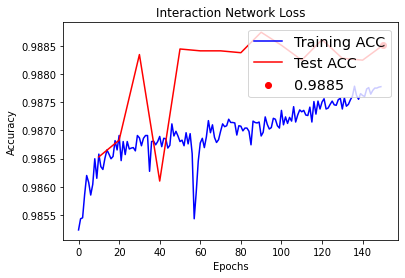

In [10]:
model = make_model(
    name = "Unet",
    inputs = [{'shape': (None, 1), 'name': "node_attributes", 'dtype': 'float32', 'ragged': True},
            {'shape': (None, 1), 'name': "edge_attributes", 'dtype': 'float32', 'ragged': True},
            {'shape': (None, 2), 'name': "edge_indices", 'dtype': 'int64', 'ragged': True}],
    input_embedding = {"node": {"input_dim": 55, "output_dim": 64},
                       "edge": {"input_dim": 10, "output_dim": 64}},

    output_embedding =  'graph',
    output_mlp = {"use_bias": [True, True, False], "units": [140, 70, 1],
                "activation": ['relu', 'relu', 'sigmoid']},
    gcn_args = {"units": 64, "use_bias": True, "activation": 'relu', "pooling_method": 'mean', 
                "normalize_by_weights": False},
)

# Set learning rate and epochs
learning_rate_start = 1e-3
learning_rate_stop = 1e-4
epo = 150
epomin = 100
epostep = 10

# Compile model with optimizer and loss
optimizer = tf.keras.optimizers.Adam(lr=learning_rate_start)
cbks = LinearLearningRateScheduler(learning_rate_start, learning_rate_stop, epomin, epo)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              weighted_metrics=['accuracy'])
print(model.summary())

# Start and time training
start = time.process_time()
hist = model.fit(xtrain, ytrain,
                 epochs=epo,
                 batch_size=32,
                 callbacks=[cbks],
                 validation_freq=epostep,
                 validation_data=(xtest, ytest),
                 verbose=2
                 )
stop = time.process_time()
print("Print Time for taining: ", stop - start)

# Get loss from history
trainlossall = np.array(hist.history['accuracy'])
testlossall = np.array(hist.history['val_accuracy'])
acc_valid = testlossall[-1]

# Plot loss vs epochs
plt.figure()
plt.plot(np.arange(trainlossall.shape[0]), trainlossall, label='Training ACC', c='blue')
plt.plot(np.arange(epostep, epo + epostep, epostep), testlossall, label='Test ACC', c='red')
plt.scatter([trainlossall.shape[0]], [acc_valid], label="{0:0.4f} ".format(acc_valid), c='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Interaction Network Loss')
plt.legend(loc='upper right', fontsize='x-large')
plt.show()

In [16]:
probability = model.predict(xtest)
predictions = np.round(probability)
comparison = np.concatenate((predictions, ytest, probability), axis=1)
# print(comparison)

hole = 0
true = 0
false = 0
for value in comparison:
    if value[1] == 1.:
        hole += 1
        print(value)
        if value[0] == 0.:
            false +=1
        else:
            true +=1
print(f"{true}/{hole}")
print(f"{false}/{hole}")

[1.        1.        0.9963907]
[0.         1.         0.03103951]
[1.         1.         0.83159018]
[0.         1.         0.24255177]
[0.         1.         0.10983694]
[0.         1.         0.26900783]
[0.         1.         0.24052164]
[0.         1.         0.21462703]
[1.         1.         0.55463922]
[0.         1.         0.01093712]
[1.         1.         0.69056833]
[1.         1.         0.54109925]
[1.        1.        0.6750797]
[0.         1.         0.14153728]
[0.         1.         0.36008441]
[0.        1.        0.0544869]
[0.         1.         0.10983694]
[0.         1.         0.09656662]
[0.         1.         0.01428521]
[0.         1.         0.03504592]
[0.         1.         0.00657487]
[0.         1.         0.10983694]
[1.         1.         0.67166758]
[0.         1.         0.03103951]
[0.         1.         0.38723648]
[0.         1.         0.11512536]
[0.         1.         0.26742119]
[1.         1.         0.67405063]
[0.         1.         0.1098

In [12]:
save_object('saved_objects/rags', rags)
save_object('saved_objects/neighbor_graphs', neighbor_graphs)
save_object('saved_objects/labels', labels)
save_object('saved_objects/nodes', nodes)
save_object('saved_objects/edges', edges)
save_object('saved_objects/edge_indices', edge_indices)
model.save('/home/daniel/Praca inżynierska/DetectingInflammationsInImagesOfSacroiliacJoint/saved_objects')

In [53]:
rags = load_object('saved_objects/rags')
neighbor_graphs = load_object('saved_objects/neighbor_graphs')
nodes = load_object('saved_objects/nodes')
edges = load_object('saved_objects/edges')
edge_indices = load_object('saved_objects/edge_indices')
labels = load_object('saved_objects/labels')
model = keras.models.load_model('/home/daniel/Praca inżynierska/DetectingInflammationsInImagesOfSacroiliacJoint/saved_objects')